In [1]:
import sqlite3
from django.shortcuts import render
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
from pytrends.request import TrendReq
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime, date, timedelta
from regex import F
import requests
import re

In [2]:
def index(request):
    return render(request, 'ioneu/index.html') 

In [3]:
company = '천일엔지니어링'

# 기업의 산업을 Company Table에서 산업1,2,3,4 로 받아와야함
industries = []

conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

cur = conn.cursor()

cur.execute(f"""
select 산업1, 산업2, 산업3, 산업4
from Company
where 기업명 like '%{company}%'
;
""")

rows = cur.fetchall()
for i in range(len(rows[0])):
    if type(rows[0][i]) == type(None):
        pass
    else:
        industries.append(rows[0][i])

In [4]:
type(rows[0][3])

NoneType

In [5]:
industries

['기계', '설비', '자동차']

In [6]:
# Connection 닫기
conn.close()

In [7]:
pytrends = TrendReq(hl='ko', tz=540)

pytrends.build_payload(kw_list = industries, cat=0, timeframe="today 5-y", geo="KR", gprop="")

# GoogleTrends(RelatedQueries) 워드클라우드
data_queries = pytrends.related_queries()
data_queries = data_queries[industries[0]]['top']

for i in range(len(data_queries)):
    data_queries['query'][i] = data_queries['query'][i].replace(" ", "")

freq = dict(zip(data_queries["query"], data_queries["value"]))

C:\Users\IBK\AppData\Local\Temp\ipykernel_47856\2013509708.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_queries['query'][i] = data_queries['query'][i].replace(" ", "")


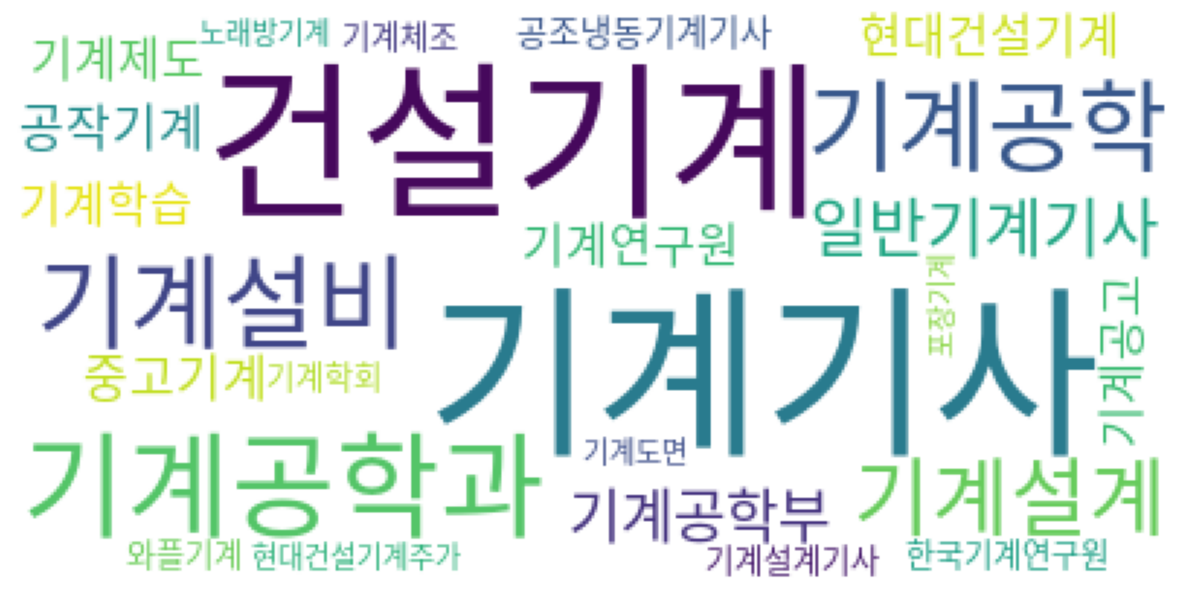

In [8]:
wordcloud = WordCloud(font_path = "../../Data/Data_Processing/Fonts/NotoSansKR-Regular.otf", background_color="white")

word = plt.figure(figsize=(15,10))
word = plt.imshow(wordcloud.generate_from_frequencies(freq))
word = plt.axis("off")
word = plt.savefig('../Data/wordcloud_%s.png' % industries[0])

In [9]:
wordcloud = open('../Data/wordcloud_%s.png' % industries[0])

In [10]:
wordcloud

<_io.TextIOWrapper name='../Data/wordcloud_기계.png' mode='r' encoding='cp949'>

In [11]:
# GoogleTrends(InterestOverTime) 산업 추이 그래프()
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

data = pytrends.interest_over_time()

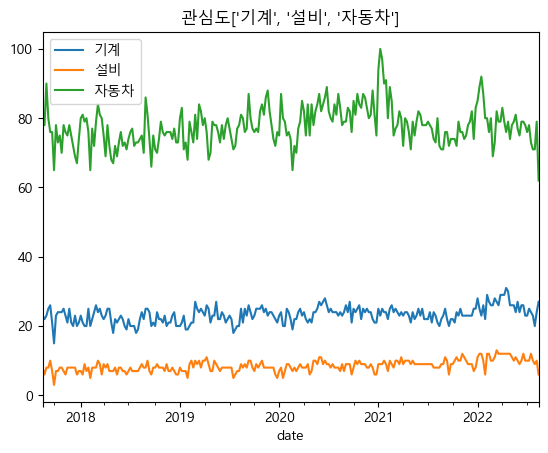

In [12]:
image = data.plot(title = '관심도%s' % industries)
fig = image.get_figure()
fig.savefig('../Data/graph_%s.png' % industries)

In [13]:
graph = open('../Data/graph_%s.png' % industries)

In [14]:
graph

<_io.TextIOWrapper name="../Data/graph_['기계', '설비', '자동차'].png" mode='r' encoding='cp949'>

In [15]:
from bs4 import BeautifulSoup
from datetime import datetime, date, timedelta
from regex import F
import requests
import pandas as pd
import re
import sqlite3
from django.shortcuts import render

In [16]:
def day(week):
    now = datetime.now()
    e_date = now - timedelta(weeks=week)
    #s_date = s_date.strftime("%Y.%m.%d")
    e_date = e_date.strftime("%Y.%m.%d")

    return e_date

In [17]:
def NaverNews(maxpage, query, sort, s_date, e_date, osc, nos):
    title_text=[]
    link_text=[]
    source_text=[]
    date_text=[]
    contents_text=[]
    result={}

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지

    def date_cleansing(test):
        try:
            #지난 뉴스
            #머니투데이  10면1단  2018.11.05.  네이버뉴스   보내기
            pattern = '\d+.(\d+).(\d+).'  #정규표현식
        
            r = re.compile(pattern)
            match = r.search(test).group(0)  # 2018.11.05.
            date_text.append(match)
            #return match
            
        except AttributeError:
            #최근 뉴스
            #이데일리  1시간 전  네이버뉴스   보내기  
            pattern = '\w* (\d\w*)'     #정규표현식 
            
            r = re.compile(pattern)
            match = r.search(test).group(1)
            date_text.append(match)
            #return match

    def contents_cleansing(contents):
        first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '', 
                                        str(contents)).strip()  #앞에 필요없는 부분 제거
        second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', 
                                        first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
        third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
        contents_text.append(third_cleansing_contents)
        #return contents_text

    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query +"&sm=tab_opt&sort="+ sort + "&photo=0&field=0&pd=3" +"&ds=" + s_date + "&de=" + e_date + "&docid=&related=0&mynews=0&office_type=" + '&office_section_code='+ osc + '&news_office_checked='+ nos + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "&is_sug_officeid=0" + "%2Ca%3A&start=" + str(page)
        # office_section_code=11&news_office_checked=1143
        
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 추출
        atags = soup.select('.news_tit')
        for atag in atags:
            title_text.append(atag.text)     #제목
            link_text.append(atag['href'])   #링크주소
            
        #신문사 추출
        source_lists = soup.select('.info_group > .press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사
        
        #날짜 추출 
        date_lists = soup.select('.info_group > span.info')
        for date_list in date_lists:
            # 1면 3단 같은 위치 제거
            if date_list.text.find("면") == -1:
                date_text.append(date_list.text)
        
        #본문요약본
        contents_lists = soup.select('.news_dsc')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화
        

        #모든 리스트 딕셔너리형태로 저장
        result= {"date" : date_text , "title":title_text , "source" : source_text , "contents": contents_text ,"link":link_text }
        #print(page)
        
        df = pd.DataFrame(result)  #df로 변환
        page += 10

    return df

In [18]:
keyword = NaverNews(maxpage = '300', query = company, sort = '0', s_date = day(0), e_date= day(52), osc = '', nos = '')

In [19]:
keyword = keyword.drop_duplicates(['title'], keep=False, ignore_index=True)

In [20]:
now = datetime.now()

outputFileName = 'News_%s.csv' % (company)
RESULT_PATH = '../Data/'

keyword.to_csv(RESULT_PATH + outputFileName, encoding='utf-8-sig', index=False)

In [21]:
news = open(RESULT_PATH + outputFileName)

In [22]:
news

<_io.TextIOWrapper name='../Data/News_천일엔지니어링.csv' mode='r' encoding='cp949'>

In [23]:
import sqlite3
from django.shortcuts import render

In [24]:
# WelfareCompany
# 회사 리스트 생성
company = []

hashtag = '성과보상'

# SQLite DB 연결
conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

# Connection 으로부터 Cursor 생성
cur = conn.cursor()

# SQL 쿼리 실행
cur.execute(f"""
select replace(replace(replace(기업명, " ", ""), "(주)", ""), "주식회사", "") as 기업명, 주요사업, 산업1, 산업2, 성과보상, 열린문화, 건강한삶, 역량성장
from Company
where {hashtag} = 1;
""")

# 데이타 Fetch
rows = cur.fetchall()
for row in rows:
    company.append(row)

# Connection 닫기
conn.close()

In [25]:
rows

[('선일금고제작', '금고, 금고제작', '제조업', None, 1, 1, 1, 1),
 ('씨티엔에스', '맞춤형 이차전지 배터리팩 제작, Smart e-Mobility 신제품개발', '기계', '설비', 0, 1, 0, 1),
 ('오리온테크놀리지', '선박전장품제조, 산업용디스플레이제조', '조선', '항공', 1, 1, 1, 1),
 ('피엔디티', '자동차부품 제조', '기계', '설비', 0, 0, 1, 1),
 ('베트올', '동물용 의료기기 제조업', '제조업', None, 1, 0, 1, 1),
 ('한국조명', 'LED', '반도체', '광학', 1, 0, 0, 1),
 ('아이씨디', '디스플레이용 식각장비', '반도체', '광학', 1, 1, 1, 1),
 ('에몬스가구', '가정용 목재 가구 제조, 도소매, 판매', '가구', '목재', 0, 0, 1, 1),
 ('유창하이텍', '유공합부품 제조, 무역', '제조업', None, 1, 1, 1, 1)]

In [26]:
# FinancePolicy
finance_policy = []

# SQLite DB 연결
conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

# Connection 으로부터 Cursor 생성
cur = conn.cursor()

# SQL 쿼리 실행
cur.execute(f"""
select b.해시태그, a.pblancNm as 정책명
from 기업정책 as a
join Company as b
on b.해시태그 = a.pldirSportRealmLclasCodeNm
where b.해시태그 = '금융'
group by a.pblancNm
limit 3
;
""")

# 데이타 Fetch
rows = cur.fetchall()
for row in rows:
    finance_policy.append(row)

# Connection 닫기
conn.close()

In [27]:
finance_policy

[('금융', '2022년 3차 중소벤처기업부 소관 중소기업 정책자금 융자계획 정정 공고'),
 ('금융', '2022년 SPLASH(스타트업 해외 투자 유치를 위한 글로벌 IR) 참여기업 모집 공고'),
 ('금융', '2022년 관광진흥개발기금 신용보증부 운영자금 특별융자 지원지침 공고')]

In [28]:
# CompanyPolicy
policy = []

hashtag = '금융'

# SQLite DB 연결
conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

# Connection 으로부터 Cursor 생성
cur = conn.cursor()

# SQL 쿼리 실행
cur.execute(f"""
select b.해시태그, a.pblancNm as 정책명
from 기업정책 as a
join Company as b
on b.해시태그 = a.pldirSportRealmLclasCodeNm
where b.해시태그 = "{hashtag}"
group by a.pblancNm
limit 3
;
""")

# 데이타 Fetch
rows = cur.fetchall()
for row in rows:
    policy.append(row)

In [29]:
policy

[('금융', '2022년 3차 중소벤처기업부 소관 중소기업 정책자금 융자계획 정정 공고'),
 ('금융', '2022년 SPLASH(스타트업 해외 투자 유치를 위한 글로벌 IR) 참여기업 모집 공고'),
 ('금융', '2022년 관광진흥개발기금 신용보증부 운영자금 특별융자 지원지침 공고')]

In [30]:
# YouthPolicy
# 청년정책(서울, 대구, 부산, ...) 리스트 생성
policy = []

hashtag = '서울'

# SQLite DB 연결
conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

# Connection 으로부터 Cursor 생성
cur = conn.cursor()

# SQL 쿼리 실행
cur.execute(f"""
select polyBizSjnm, polyBizSecd, polyItcnCn
from 청년정책_v3
where polyBizSecd = '{hashtag}'
;
""")

# 데이타 Fetch
rows = cur.fetchall()
for row in rows:
    policy.append(row)

# Connection 닫기
conn.close()

In [31]:
policy

[('지역주도형 청년일자리사업',
  '서울',
  '관내의 미취업청년과 사회적경제기업을 연계하여 청년에게는 일자리와 취업교육을 제공하고 기업에게는 맞춤형 인력과 임금을 지원하는 사업'),
 ('특성화고 학생을 위한 취업지원',
  '서울',
  '취업지원 프로그램에 상대적으로 노출될 기회가 적은 특성화고 학생을 대상으로 취업역량강화를 위한 교육 실시 등으로 취업률을 고취하고 중소기업과 청년간의 일자리 미스매칭 문제해소에 기여하고자 함'),
 ('지역주도형 청년일자리 사업(청년 신규일자리 창출)', '서울', '마을기반 사회적기업, 협동조합, 비영리단체 등에 일자리 제공'),
 ('지역주도형 청년일자리사업(도서관지킴이 운영)',
  '서울',
  '도서관 운영지원 사업을 통해 지역 청년들에게 전문지식 습득 및 실무능력 함양의 기회를 제공하고자 함')]

In [32]:
# CompanyName
# 회사 리스트 생성
company = []

company_name = '선일금고제작'

# SQLite DB 연결
conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

# Connection 으로부터 Cursor 생성
cur = conn.cursor()

# SQL 쿼리 실행
cur.execute(f"""
select replace(replace(replace(기업명, " ", ""), "(주)", ""), "주식회사", "") as 기업명
from Company
where 기업명 like '%{company_name}%'
""")

# 데이타 Fetch
company = cur.fetchall()

# Connection 닫기
conn.close()

In [33]:
company[0][0]

'선일금고제작'

C:\Users\Cyber\AppData\Local\Temp\ipykernel_3644\3903185862.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_queries['query'][i] = data_queries['query'][i].replace(" ", "")


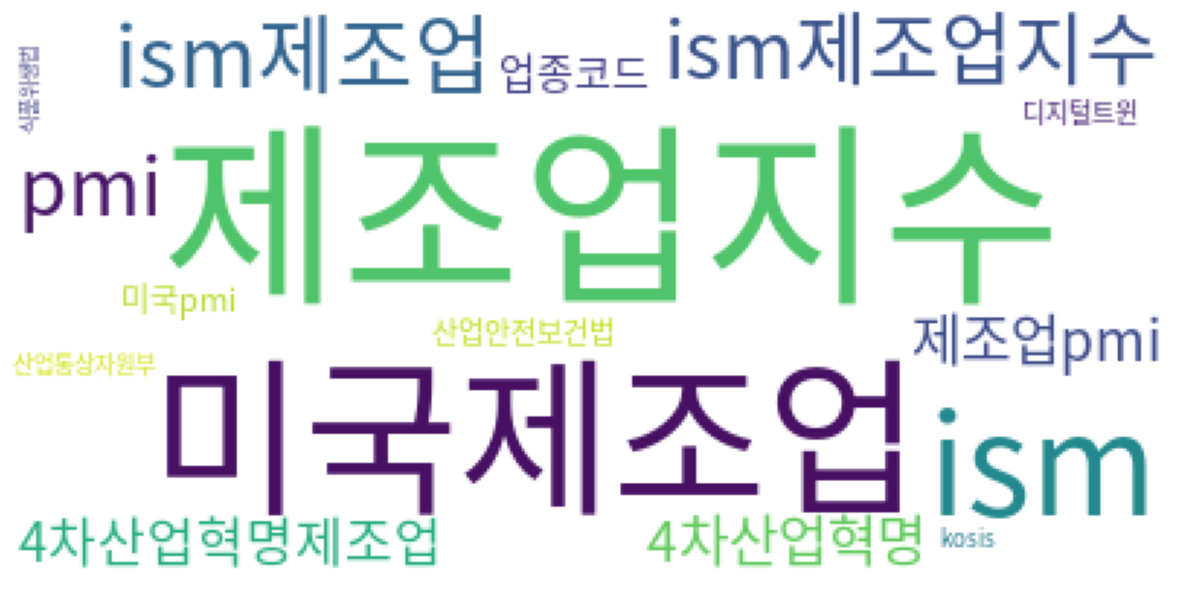

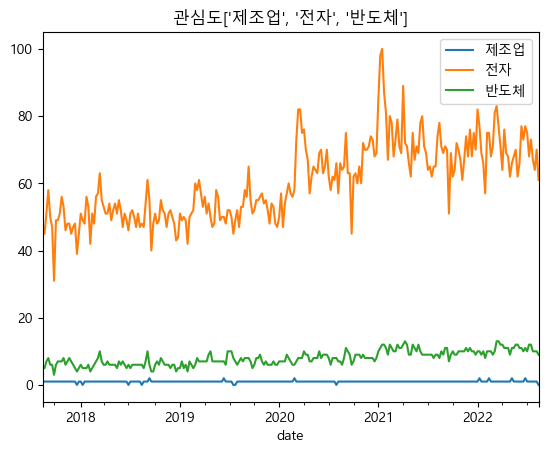

In [2]:
# CompanyInfo
# 기업의 산업을 Company Table에서 산업1,2,3,4 로 받아와야함
industries = []

company = '에스티엠테크놀로지'

conn = sqlite3.connect("../../Data/Data_Processing/Data/IONEJOB.db")

cur = conn.cursor()

cur.execute(f"""
select 산업1, 산업2, 산업3, 산업4
from Company
where 기업명 like '%{company}%'
;
""")

rows = cur.fetchall()
for i in range(len(rows[0])):
    if type(rows[0][i]) == type(None):
        pass
    else:
        industries.append(rows[0][i])

conn.close()

pytrends = TrendReq(hl='ko', tz=540)

pytrends.build_payload(kw_list = industries, cat=0, timeframe="today 5-y", geo="KR", gprop="")

# GoogleTrends(RelatedQueries) 워드클라우드
data_queries = pytrends.related_queries()
data_queries = data_queries[industries[0]]['top']

for i in range(len(data_queries)):
    data_queries['query'][i] = data_queries['query'][i].replace(" ", "")

freq = dict(zip(data_queries["query"], data_queries["value"]))
wordcloud = WordCloud(font_path = "../../Data/Data_Processing/Fonts/NotoSansKR-Regular.otf", background_color="white")

word = plt.figure(figsize=(15,10))
word = plt.imshow(wordcloud.generate_from_frequencies(freq))
word = plt.axis("off")
word = plt.savefig('../Data/wordcloud_%s.png' % industries[0])

wordcloud = open('../Data/wordcloud_%s.png' % industries[0])


# GoogleTrends(InterestOverTime) 산업 추이 그래프()
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

data = pytrends.interest_over_time()

image = data.plot(title = '관심도%s' % industries)
fig = image.get_figure()
fig.savefig('../Data/graph_%s.png' % industries)

graph = open('../Data/graph_%s.png' % industries)

# 네이버 뉴스 제공

def day(week):
    now = datetime.now()
    e_date = now - timedelta(weeks=week)
    #s_date = s_date.strftime("%Y.%m.%d")
    e_date = e_date.strftime("%Y.%m.%d")

    return e_date

def NaverNews(maxpage, query, sort, s_date, e_date, osc, nos):
    title_text=[]
    link_text=[]
    source_text=[]
    date_text=[]
    contents_text=[]
    result={}

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지

    def date_cleansing(test):
        try:
            #지난 뉴스
            #머니투데이  10면1단  2018.11.05.  네이버뉴스   보내기
            pattern = '\d+.(\d+).(\d+).'  #정규표현식
        
            r = re.compile(pattern)
            match = r.search(test).group(0)  # 2018.11.05.
            date_text.append(match)
            #return match
            
        except AttributeError:
            #최근 뉴스
            #이데일리  1시간 전  네이버뉴스   보내기  
            pattern = '\w* (\d\w*)'     #정규표현식 
            
            r = re.compile(pattern)
            match = r.search(test).group(1)
            date_text.append(match)
            #return match

    def contents_cleansing(contents):
        first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '', 
                                        str(contents)).strip()  #앞에 필요없는 부분 제거
        second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', 
                                        first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
        third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
        contents_text.append(third_cleansing_contents)
        #return contents_text

    while page <= maxpage_t:
        url = "https://search.naver.com/search.naver?where=news&query=" + query +"&sm=tab_opt&sort="+ sort + "&photo=0&field=0&pd=3" +"&ds=" + s_date + "&de=" + e_date + "&docid=&related=0&mynews=0&office_type=" + '&office_section_code='+ osc + '&news_office_checked='+ nos + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "&is_sug_officeid=0" + "%2Ca%3A&start=" + str(page)
        # office_section_code=11&news_office_checked=1143
        
        response = requests.get(url)
        html = response.text

        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(html, 'html.parser')

        #<a>태그에서 제목과 링크주소 추출
        atags = soup.select('.news_tit')
        for atag in atags:
            title_text.append(atag.text)     #제목
            link_text.append(atag['href'])   #링크주소
            
        #신문사 추출
        source_lists = soup.select('.info_group > .press')
        for source_list in source_lists:
            source_text.append(source_list.text)    #신문사
        
        #날짜 추출 
        date_lists = soup.select('.info_group > span.info')
        for date_list in date_lists:
            # 1면 3단 같은 위치 제거
            if date_list.text.find("면") == -1:
                date_text.append(date_list.text)
        
        #본문요약본
        contents_lists = soup.select('.news_dsc')
        for contents_list in contents_lists:
            contents_cleansing(contents_list) #본문요약 정제화
        

        #모든 리스트 딕셔너리형태로 저장
        result= {"date" : date_text , "title":title_text , "source" : source_text , "contents": contents_text ,"link":link_text }
        #print(page)
        
        df = pd.DataFrame(result)  #df로 변환
        page += 10

    return df

keyword = NaverNews(maxpage = '300', query = company, sort = '0', s_date = day(0), e_date= day(52), osc = '', nos = '')
keyword = keyword.drop_duplicates(['title'], keep=False, ignore_index=True)

now = datetime.now()

outputFileName = 'News_%s.csv' % (company)
RESULT_PATH = '../Data/'

keyword.to_csv(RESULT_PATH + outputFileName, encoding='utf-8-sig', index=False)

news = open(RESULT_PATH + outputFileName)

In [35]:
news

<_io.TextIOWrapper name='../Data/News_선일금고제작.csv' mode='r' encoding='cp949'>